<a href="https://colab.research.google.com/github/AshwinUnnikrishnan/DeepLearning7150/blob/main/LearnPytorch/1_Pytorch_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to Read Pytorch
===================

These five python notebooks are an introduction to core pytorch idioms.

Pytorch is a numerical library that makes it very convenient to train deep networks on GPU hardware. It introduces a new programming vocabulary that takes a few steps beyond regular numerical python code. Although pytorch code can look simple and concrete, much of of the subtlety of what happens is invisible, so when working with pytorch code it helps to thoroughly understand the runtime model.

For example, consider this code:

```
torch.nn.cross_entropy(model(images.cuda()), labels.cuda()).backward()
optimizer.step()
```

It looks like it computes some function of `images` and `labels` without storing the answer.  But actually the purpose of this code is to update some hidden parameters that are not explicit in this formula.  This line of code moves batches of image and label data from CPU to the GPU; runs a neural network to make a prediction; constructs a computation graph describing how the loss depends on the network parameters; annotates every network parameter with a gradient; then finally it runs one step of optimization to adjust every parameter of the model.  During all this, the CPU does not see any of the actual answers.  That is intentional for speed reasons.  All the numerical computation is done on the GPU asynchronously and kept there.

The berevity of the code is what makes pytorch code fun to write.  But it also reflects why pytorch can be so fast even though the python interpreter is so slow. Although the main python logic slogs along sequentially in a single very slow CPU thread, just a few python instructions can load a huge amount of work into the GPU.  That means the program can keep the GPU busy churning through massive numerical computations, for most part, without waiting for the python interpreter.

Is is worth understanding five core idioms that work together to make this possible.  This tutorial has five Colab notebooks, one for each topic:

 1. GPU Tensor arithmetic ([this notebook on colab](https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks/1-Pytorch-Introduction.ipynb)): the notation for manipulating n-dimensional arrays of numbers on CPU or GPU.
 2. [Autograd](./2-Pytorch-Autograd.ipynb): how to build a tensor computation graph and use it to get derivatives of any scalar with respect to any input.
 3. [Optimization](./3-Pytorch-Optimizers.ipynb): ways to update tensor parameters to reduce any computed objective, using autograd gradients.
 4. [Network modules](./4-Pytorch-Modules.ipynb): how pytorch represents neural networks for convenient composition, training, and saving.
 5. [Datasets and Dataloaders](./5-Pytorch-Dataloader.ipynb): for efficient multithreaded prefetching of large streams of data.

The key ideas are illustrated with small, illustrated, hackable examples, and there are links to other reference material and resources.

All the notebooks can be run on Google Colab where some GPU compuation can be used for free, or they can be run on your own local Jupyter notebook server.

The examples should all work with python 3.5 or newer and pytorch 1.0 or newer.

The original [code on github can be found here](https://github.com/davidbau/how-to-read-pytorch).

--- [*David Bau, July 2020*](http://davidbau.com/archives/2020/07/05/davids_tips_on_how_to_read_pytorch.html)

Topic 1: pytorch Tensors
===============

The first big trick for doing math fast on a modern computer is to do giant array operations all at once.

To faciliate this, pytorch provides a [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) class that is a lookalike to the older python numerical library [`numpy.ndarray`](https://numpy.org/doc/1.18/reference/arrays.ndarray.html).  Just like a numpy `ndarray`, the pytorch `Tensor` stores a d-dimensional array of numbers, where d can be zero or more, and where the contained numbers can be any of the usual selection of float or integer types.  Pytorch is designed to feel just like numpy: almost all the numpy operations are also available on torch tensors. But if something is missing, torch tensors can be directly converted to and from numpy using `x.numpy()` and `torch.from_numpy(a)`. So what is different and why did the pytorch authors bother to reimplement this whole library?

**There are two things that pytorch Tensors have that numpy arrays lack:**

 1. pytorch Tensors can live on either **GPU or CPU** (numpy is cpu-only).
 2. pytorch can automatically track tensor computations to enable **automatic differentiation**.

In the following sections on this page we talk about the basics of the Tensor API as well as point (1) - how to work with GPU and CPU tensors.  A discussion of (2) can be found in the next notebook, [2. Autograd](https://colab.research.google.com/github/davidbau/pytorch-tutorial/blob/master/notebooks/2-Pytorch-Autograd.ipynb).


Basic operations in the Tensor API
----------------------------------

Pytorch is not very different from numpy, although the pytorch API has more convenience methods such as `x.clamp(0).pow(2)` (supporting a chained method style, as is popular in Javascript libraries, so you don't need to say the verbose `numpy.clip(numpy.pow(x, 2), 0)`). So code is often shorter in pytorch.  A brief overview:

**Elementwise operations.** Most tensor operations are simple (embarassingly parallelizable) elementwise operations, where the same math is done on every element of the array.  `x+y`, `x*y`, `x.abs()`, `x.pow(3)`, etc.  Unlike Matlab, `*` is for element-wise multiplication, not matrix-multiplication.

**Copy semantics by default.** Almost all operations, including things like `x.sort()`, return a new copy of the tensor without overwriting the input tensors.  The exceptions are functions that end in an underscore such as `x.mul_(2)` which doubles the contents of x in-place.

**Common reduction operations.**  There are some common operations such as `max`, `min`, `mean`, `sum` that reduce the array by one or more dimension. In pytorch, you can specify which dimension you want to reduce by passing the argument `dim=n`.

**Why does min return two things?** Note that `[data, indexes] = x.sort(dim=0)` and `[vals, indexes] = x.min(dim=0)` return the pair of both the answer and the index values, so you do not need to separately recompute `argsort` or `argmin` when you need to know where the min came from.

**What about linear algebra?** It's there.  `torch.mm(a,b)` is matrix multiplication, `torch.inverse(a)` inverts, `torch.eig(a)` gets eigenvalues, etc.

The other thing to know is that pytorch tends to be very fast, often much faster than numpy even on CPU, because its implementation is aggressively parallelized behind-the-scenes.  Pytorch is willing to use multiple threads in situations where numpy just uses one.

See the [reference for Tensor methods](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) for what comes built-in.  A simple demo of some vectors:



In [1]:
import math, numpy, torch
from matplotlib import pyplot as plt

# Make a vector of 101 equally spaced numbers from 0 to 5.
x = torch.linspace(0, 5, 101)

# Print the first five things in x.
print(x[:5])

tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000])


### Exercise

Print the last five things in x.

In [2]:
# TODO: Print the last five things in x (instead of the first five)
print(x[-5:])
print('TODO')

tensor([4.8000, 4.8500, 4.9000, 4.9500, 5.0000])
TODO


The shape of x is torch.Size([101])
The shape of y1=x.sin() is torch.Size([101])
The shape of y2=x ** x.cos() is torch.Size([101])
The shape of y3=y2 - y1 is torch.Size([101])
The shape of y4=y3.min() is torch.Size([]), a zero-d scalar


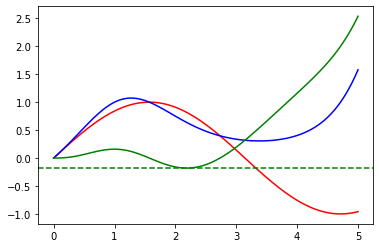

In [3]:
# Do some vector computations.
y1, y2 = x.sin(), x ** x.cos()
y3 = y2 - y1
y4 = y3.min()

# Print and plot some answers.
print(f'The shape of x is {x.shape}')
print(f'The shape of y1=x.sin() is {y1.shape}')
print(f'The shape of y2=x ** x.cos() is {y2.shape}')
print(f'The shape of y3=y2 - y1 is {y3.shape}')
print(f'The shape of y4=y3.min() is {y4.shape}, a zero-d scalar')

plt.plot(x, y1, 'red', x, y2, 'blue', x, y3, 'green')
plt.axhline(y4, color='green', linestyle='--')
plt.show()

### Exercise

Plot y3 clamped between 0.0 and 1.0.

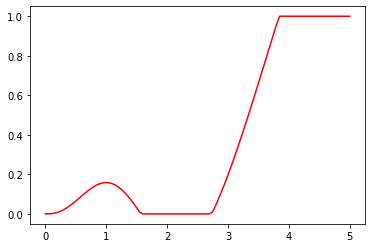

In [4]:
# TODO: Plot y3 clamped between 0.0 and 1.0.
y3 = y3.clamp(0.0,1.0)
plt.plot(x,y3, 'red')
plt.show()


Subscripts and multiple dimensions
----------------------------------

Pytorch code is full of multidimensional arrays.  The key to reading this kind of code is stopping to think about the careful, sometimes tangled, use of multiple array subscripts.

**Slicing.** As normal in python, you can use `[min:max:stride]` to slice ranges, and multidimensional subscripts like `x[2,0,1,9]` work as you would expect (selecting the 9th entry of the of the 1st of the 0th of the 2nd entry of `x`; and can be used with slices like `x[0:3,2,:,:]`.  The special slice `:` selects the whole range in that dimension.

**Unsqueezing to add a dimension, and broadcasting.** While a single integer subscript like `x[0]` eliminates a dimension, the special subscript `x[None]` does the reverse and adds an extra dimension of size one.

An extra dimension of size one is more useful than you might imagine, because pytorch (similar to numpy) can combine different-shaped arrays as long as the shape differences appear only on dimensions of size one by **broadcasting** the singleton dimensions.  An example that uses broadcasting to calculate an outer product is illustrated below.

**Fancy indexing.** Lots more can be done by passing numerical arrays or boolean array masks as subscripts.  The reshuffling possibilities can get quite intricate; the rules are modeled on the capabilties in numpy.  For details see [Numpy fancy indexing](https://numpy.org/doc/stable/user/basics.indexing.html).

Here is a demonstration of simple tensor reshaping.

m is tensor([[0.0793, 0.7899, 0.3311, 0.4782, 0.3084],
        [0.3818, 0.6004, 0.6670, 0.7390, 1.0044]]), and m[1,2] is 0.667029857635498

column zero, m[:,0] is tensor([0.0793, 0.3818])
row zero m[0,:] is tensor([0.0793, 0.7899, 0.3311, 0.4782, 0.3084])

The dot product of rows (m[0,:] * m[1,:]).sum() is 1.3885798454284668

The outer product of rows m[0,:][None,:] * m[1,:][:,None] is:
tensor([[0.0303, 0.3016, 0.1264, 0.1826, 0.1178],
        [0.0476, 0.4743, 0.1988, 0.2871, 0.1852],
        [0.0529, 0.5269, 0.2209, 0.3190, 0.2057],
        [0.0586, 0.5837, 0.2447, 0.3534, 0.2279],
        [0.0796, 0.7934, 0.3326, 0.4803, 0.3098]])


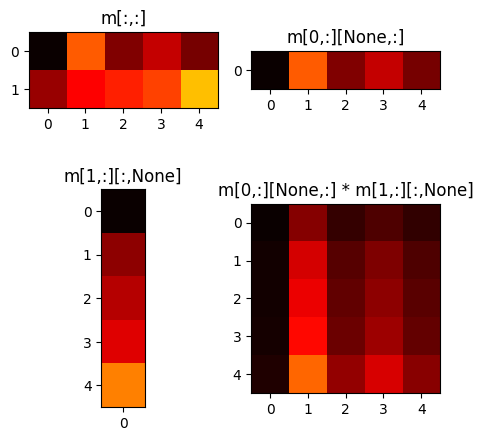

In [33]:
import torch
from matplotlib import pyplot as plt

# Make an array of normally distributed randoms.
m = torch.randn(2, 5).abs()
print(f'm is {m}, and m[1,2] is {m[1,2]}\n')
print(f'column zero, m[:,0] is {m[:,0]}')
print(f'row zero m[0,:] is {m[0,:]}\n')
dot_product = (m[0,:] * m[1,:]).sum()
print(f'The dot product of rows (m[0,:] * m[1,:]).sum() is {dot_product}\n')
outer_product = m[0,:][None,:] * m[1,:][:,None]
print(f'The outer product of rows m[0,:][None,:] * m[1,:][:,None] is:\n{outer_product}')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5), dpi=100)
def color_mat(ax, m, title):
    ax.set_title(title)
    ax.imshow(m, cmap='hot', vmax=1.5, interpolation='nearest')
    ax.get_xaxis().set_ticks(range(m.shape[1]))
    ax.get_yaxis().set_ticks(range(m.shape[0]))
color_mat(ax1, m, 'm[:,:]')
color_mat(ax2, m[0,:][None,:], 'm[0,:][None,:]')
color_mat(ax3, m[1,:][:,None], 'm[1,:][:,None]')
color_mat(ax4, outer_product, 'm[0,:][None,:] * m[1,:][:,None]')
fig.tight_layout()
fig.show()

In [51]:
print(m[0,:])
print(m[0,:][None,:])
print(m[1,:][:,None])

tensor([0.0793, 0.7899, 0.3311, 0.4782, 0.3084])
tensor([[0.0793, 0.7899, 0.3311, 0.4782, 0.3084]])
tensor([[0.3818],
        [0.6004],
        [0.6670],
        [0.7390],
        [1.0044]])


In [53]:
x = 0.7899 * 0.3818
x

0.30158382

### Exercise

Use `torch.mm` to compute `outer_product` and `dot_product`.

Explain to yourself why order matters when using torch.mm but not when using `*`. 

In [35]:
print(m[0,:][None,:].shape)
print(torch.transpose(m[0,:][None,:],0,1).shape)

torch.Size([1, 5])
torch.Size([5, 1])


In [54]:
# TODO Use torch.mm to compute outer_product and dot_product.

outer = torch.mm(m[1,:][:,None], m[0,:][None,:])

#outer = torch.outer(m[1,:], m[0,:])
print(outer == outer_product)
dot = torch.mm(m[1,:][None,:], m[0,:][:,None])
print(dot == dot_product)

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])
tensor([[True]])


Devices and types
-----------------

One of the big reasons to use pytorch instead of numpy is that pytorch can do computations on the GPU.  But because moving data on and off of a GPU device is more expensive than keeping it within the device, pytorch treats a Tensor's **computing device** as pseudo-type that requires explicit declaration and explicit conversion.  Here are some things to know about pytorch devices and types:

**Single precision CPU default.** By default a torch tensor will be stored on the CPU and will store single-precision 32-bit `torch.float` values.

**Specifying data type.** To store a different data type such as integers, use the argument `dtype=torch.long` when you create the Tensor.  For example, `z = torch.zeros(10, dtype=torch.long)`.  This is similar to numpy with minor differences.  See the [Tensor reference](https://pytorch.org/docs/stable/tensors.html) for all the types.

**Specifying GPU.** To store the tensor on the GPU, specify `device='cuda'` when you make it, for example `identity_matrix = torch.eye(5, device='cuda')`.  (Instead `device='cpu'` indicates the default CPU storage).

Even on a multi-GPU machine it is fine to pretend there is only one GPU.  Setting the environment variable `CUDA_VISIBLE_DEVICES=3` before you start the program will set up the process to see GPU\#3 as the only visible GPU when it runs.

As an aside, in principle you could instead target one of many GPUs with `device='cuda:3'`, but if you want to use multiple GPUs for the same computation your best bet is to a use a multiprocess utility class that manages data distribution between forked processes automatically, while each python process touches only one GPU.  When this becomes an issue, read the [DistributedDataParalllel docs](https://pytorch.org/docs/stable/distributed.html).

**Copying a tensor to a different device or type.** You cannot directly combine tensors that are on different devices (e.g., GPU vs CPU or different GPUs); this is similar to how most different-data-type combinations are also prohibited. In both cases you will need to convert types and move devices explicitly to make tensors compatible before combining them.  The `x.to(y.device)` or `x.to(y.dtype)` function can be used to do the conversion.

There are also commonly-used convenience synonyms `x.cpu()`, `x.cuda()`, `x.float()`, `x.long()`, etc. for making a copy of `x` with the specified device or type.  There is a bit of cost, so move data only when needed.

**GPU rounding is nondeterministic.** Computationally the GPU is **not** perfectly equivalent to the CPU.  To speed parallelization, the GPU does not do associative operations such as summations in a deterministic sequential order.  Since changing the order of summations can alter rounding behavior in fixed-precision arithmetic, GPU rounding can be  different from CPU results an even nondeterministic.  When the numerical algorithm is well-behaved, the difference should be small enough that you do not care, but you should know it is different. You can see this gap in the code example below.

**float is fastest.** All commodity GPU hardware is fast at single-precision 32-bit floating-point math, about 20x CPU speed.  Be aware that only expensive cards are fast at 64-bit double-precision math. If you change `torch.float` in the below example to `torch.double` on an Nvidia Titan or consumer card without hardware double-precision support, you will slow down to just-slightly-faster-than-CPU speeds.  Similarly 16-bit `torch.half` or `torch.bfloat16` or other cool options will only be faster on newer hardware, and with these data types you need to take care that the reduced precision is not damaging your results.

So `float` is the default and usually the best.

Also note that some operations (like linear algebra) are floating-point only and cannot be done on integers.

An example of some CPU versus GPU speed comparisons is below.

time using the CPU alone: 10.1 seconds
time using GPU, moving data from CPU: 2.93 seconds
time using GPU on pinned CPU memory: 0.232 seconds
time using the GPU alone: 0.152 seconds


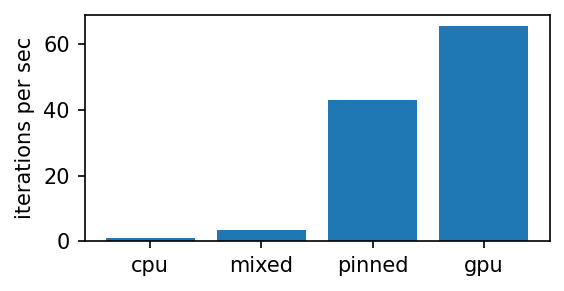

Your GPU is 66.3x faster than CPU but only 3.45x if data is repeatedly copied from the CPU
When copying from pinned memory, speedup is 43.6x
Numerical differences between GPU and CPU: 6.089336466175155e-07


In [55]:
import torch, time
from matplotlib import pyplot as plt

# Here is a demonstration of moving data between GPU and CPU.
# We multiply a batch of vectors through a big linear opeation 10 times
r = torch.randn(1024, 1024, dtype=torch.float)
x = torch.randn(32768, 1024, dtype=r.dtype)
iterations = 10

def time_iterated_mm(x, matrix):
    start = time.time()
    result = 0
    for i in range(iterations):
        result += torch.mm(matrix, x.to(matrix.device).t())
    torch.cuda.synchronize()
    elapsed = time.time() - start
    return elapsed, result.cpu()

cpu_time, cpu_result = time_iterated_mm(x.cpu(), r.cpu())
print(f'time using the CPU alone: {cpu_time:.3g} seconds')

mixed_time, mixed_result = time_iterated_mm(x.cpu(), r.cuda())
print(f'time using GPU, moving data from CPU: {mixed_time:.3g} seconds')

pinned_time, pinned_result = time_iterated_mm(x.cpu().pin_memory(), r.cuda())
#pinned memory fastens the memory copy operation from cpu to gpu, which is done
#in the above function
print(f'time using GPU on pinned CPU memory: {pinned_time:.3g} seconds')

gpu_time, gpu_result = time_iterated_mm(x.cuda(), r.cuda())
print(f'time using the GPU alone: {gpu_time:.3g} seconds')

plt.figure(figsize=(4,2), dpi=150)
plt.ylabel('iterations per sec')
plt.bar(['cpu', 'mixed', 'pinned', 'gpu'],
        [iterations/cpu_time,
         iterations/mixed_time,
         iterations/pinned_time,
         iterations/gpu_time])
plt.show()

print(f'Your GPU is {cpu_time / gpu_time:.3g}x faster than CPU'
      f' but only {cpu_time / mixed_time:.3g}x if data is repeatedly copied from the CPU')
print(f'When copying from pinned memory, speedup is {cpu_time / pinned_time:.3g}x')
print(f'Numerical differences between GPU and CPU: {(cpu_result - gpu_result).norm() / cpu_result.norm()}')

### Exercise

Repeat the benchmark using type `torch.double`.   What does that tell you about your GPU hardware?

time using the CPU alone: 20.7 seconds
time using GPU, moving data from CPU: 3.48 seconds
time using GPU on pinned CPU memory: 2.96 seconds
time using the GPU alone: 2.74 seconds


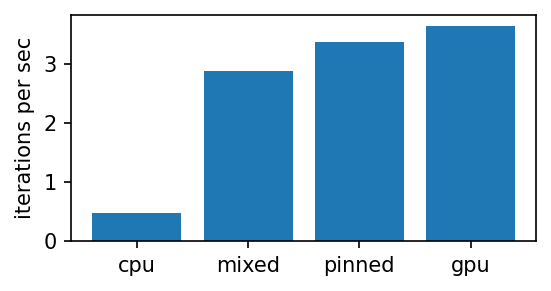

Your GPU is 7.56x faster than CPU but only 5.96x if data is repeatedly copied from the CPU
When copying from pinned memory, speedup is 6.99x
Numerical differences between GPU and CPU: 1.134851629906317e-15


In [56]:
import torch, time
from matplotlib import pyplot as plt

# Here is a demonstration of moving data between GPU and CPU.
# We multiply a batch of vectors through a big linear opeation 10 times
r = torch.randn(1024, 1024, dtype=torch.double)
x = torch.randn(32768, 1024, dtype=r.dtype)
iterations = 10

def time_iterated_mm(x, matrix):
    start = time.time()
    result = 0
    for i in range(iterations):
        result += torch.mm(matrix, x.to(matrix.device).t())
    torch.cuda.synchronize()
    elapsed = time.time() - start
    return elapsed, result.cpu()

cpu_time, cpu_result = time_iterated_mm(x.cpu(), r.cpu())
print(f'time using the CPU alone: {cpu_time:.3g} seconds')

mixed_time, mixed_result = time_iterated_mm(x.cpu(), r.cuda())
print(f'time using GPU, moving data from CPU: {mixed_time:.3g} seconds')

pinned_time, pinned_result = time_iterated_mm(x.cpu().pin_memory(), r.cuda())
#pinned memory fastens the memory copy operation from cpu to gpu, which is done
#in the above function
print(f'time using GPU on pinned CPU memory: {pinned_time:.3g} seconds')

gpu_time, gpu_result = time_iterated_mm(x.cuda(), r.cuda())
print(f'time using the GPU alone: {gpu_time:.3g} seconds')

plt.figure(figsize=(4,2), dpi=150)
plt.ylabel('iterations per sec')
plt.bar(['cpu', 'mixed', 'pinned', 'gpu'],
        [iterations/cpu_time,
         iterations/mixed_time,
         iterations/pinned_time,
         iterations/gpu_time])
plt.show()

print(f'Your GPU is {cpu_time / gpu_time:.3g}x faster than CPU'
      f' but only {cpu_time / mixed_time:.3g}x if data is repeatedly copied from the CPU')
print(f'When copying from pinned memory, speedup is {cpu_time / pinned_time:.3g}x')
print(f'Numerical differences between GPU and CPU: {(cpu_result - gpu_result).norm() / cpu_result.norm()}')

Performance tips
----------------

**GPU operations are async.** When pytorch operates on GPU tensors, the python code does not wait for computations to complete. Sp GPU calculations get queued up, and they will be done as quickly as possible in the background while your python is free to work on other things like loading the next batch of training data.

**Moving data to cpu waits for computations.** You do not need to worry about the GPU asynchrony, because as soon as you actually ask to look at the data, e.g., when you move GPU data to CPU (or print it or save it), pytorch will block and wait for the GPU operations to finish computing what you need before proceeding. The call seen above to `torch.cuda.synchronize()` flushes the GPU queue without requesting the data, but you will not need to do this unless you are doing performance timing.

**Pinned memory transfers are async and faster.** Copying data from CPU to GPU can be sped up if the CPU data is put in pinned memory (i.e., at a fixed non-swappable block of RAM).  Therefore when data loaders gather together lots of CPU data that is destined for the GPU, they should be configured to stream their results into pinned memory. See the performance comparison above.

pytorch Tensor dimension-ordering conventions
---------------------------------------------

**Multidimensional data convention.** As soon as you have more than one dimension, you need to decide how to order the axes.  To reduce confusion, most data processing follows the same global convention. In particular, much image-related data in pytorch is four dimensional, and the dimensions are ordered like this: `data[batch_index, channel_index, y_position, x_position]`, that is:

* Dimension 0 is used to index separate images within a batch.
* Dimension 1 indexes channels within an image representation (e.g., 0,1,2 = R,G,B, or more dims for more channels).
* Dimension 2 (if present) indexes the row position (y-value, starting from the top)
* Dimension 3 (if present) indexes the column position (x-value, starting from the left)

There a way to remember this ordering: adjacent entries that vary only in the last dimensions are stored physically closer in RAM; since they are often combined with each other, this could help with locality, whereas the first (batch) dimension usually just groups separate independent data points which are not combined much, so they do not need to be physically close.

Stream-oriented data without grid geometry will drop the last dimensions, and 3d grid data will be 5-dimensional, adding a depth z before y.  This same 4d-axis ordering convention is also seen in caffe and tensorflow.

Separate tensors can be put together into a single batch tensor using `torch.cat([a, b, c])` or `torch.stack([a, b, c])`.  (The difference: `cat` doesn't add any new dimensions but just concatenates along the existing 0th dimension.  `stack` adds a new 0th dimension for the batch.)

**Multidimensional linear operation convention.** When storing matrix weights or convolution weights, linear algebra conventions are followed
* Dimension 0 (number of rows) matches the output channel dimension
* Dimension 1 (number of columns) matches the input channel dimension
* Dimension 2 (if present) is the convolutional kernel y-dimension
* Dimension 3 (if present) is the convolutional kernel x-dimension

Since this convention assumes channels are arranged in different rows whereas the data convention puts different batch items in different rows, some axis transposition is often needed before applying linear algebra to the data.

**Permute and view reshape an array without moving memory.** The `permute` and `view` methods are useful for rearranging, flattening, and unflatteneing axes. `x.permute(1,0,2,3).view(x.shape[1], -1)`.  They just alter the view of the block of numbers in memory without moving any of the numbers around, so they are fast.

**Reshaping sometimes needs copying.** Some sequences of axis permutations and flattenings cannot be done without copying the data into the new order in memory; the `x.contiguous()` method copies the data into the natural order given by the current view; also `x.reshape()` is similar to `view` but will makea copy if necessary so you do not need to think about it.  See [the Tensor.view method documentation](https://pytorch.org/docs/master/tensors.html#torch.Tensor.view).


### Exercise

Use `torch.randn` to create a four-dimensional tensor `x` of size (2,3,4,5), which could store two 5x4 RGB images.

Then print three things:
 * print `x`.
 * Use `x.permute` to switch the horizontal and vertical (last two) dimensions.
 * Use `x.view` to see each image as a flat vector of 60 numbers.

In [66]:
# TODO make x of size (2,3,4,5), and print three rearrangements of x
x = torch.randn(2, 3, 4, 5)
print(x)
print(x.permute(0,1,3,2))
print(x.view(2,60))

tensor([[[[-0.8068,  0.2143, -0.0470, -1.0362, -0.1712],
          [-0.2557,  0.4968,  1.0455, -1.1886,  0.8893],
          [-0.0789, -0.7642, -1.2580, -0.9880, -0.5672],
          [ 1.7644,  1.4911, -0.6333, -0.7613, -0.9925]],

         [[ 0.3578,  0.1050, -0.5972, -0.5513, -1.8206],
          [-0.0586,  0.0938,  0.0309, -0.9118, -1.1481],
          [-1.0242, -0.5408,  0.0521,  1.2025,  0.3983],
          [ 0.3550, -0.1217,  1.9024,  0.3372, -0.2647]],

         [[-0.8423,  0.8129,  0.3415,  1.5273,  0.3944],
          [ 0.3424, -0.6074, -0.7416,  1.0262,  2.1310],
          [-0.2740, -0.8368, -1.0312,  0.7927, -0.2743],
          [-0.0174,  0.4478, -1.7244, -0.3567,  0.5952]]],


        [[[ 0.6347,  0.5672,  0.7379,  0.2021,  0.4261],
          [-0.1084, -1.0464, -0.6254,  0.4659,  0.2715],
          [ 0.3802,  0.8108, -1.2224, -0.7904, -1.3831],
          [ 1.0577,  0.7782,  0.3859,  0.2114, -0.2067]],

         [[-1.4880,  0.4681,  0.9974,  0.8369,  0.4298],
          [ 0.1250,  

## Special topic: einsum notation

Matrix multiplication can be generalized to tensors of arbitrary number of dimensions, but keeping tensor dimensions straight can be confusing.  The solution to this is [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation): assign letter variables to each axis of the input tensors, and then explicitly write down which axes end up in the output tensor.  For example, an outer product might be written as `i, j -> ij`, whereas matrix multiplication could be `ij, jk -> ik`.

Einstein notation is a topic of active development and programming language design: [here is a recent paper on the history and future of Einstein APIs.](https://openreview.net/pdf?id=oapKSVM2bcj)


In pytorch, Einstein notation is available as `einsum`.  Here is how ordinary matrix multiplication looks as einsum:

In [67]:
A = torch.randn(2,5)
B = torch.randn(5,3)

# Uncomment to see ordinary matrix multiplication
# print(torch.mm(A, B))

# Ordinary matrix multiplication written as an einsum
print(torch.einsum('ij, jk -> ik', A, B))

tensor([[-0.2300, -0.8624, -2.2039],
        [-0.5469, -0.0145, -2.6321]])


### Exercise

Make A in the shape (5, 6, 2) and B in the shape (5, 6, 3); we can think of A as a 5x6 grid of 2-dimensional vectors and B as a 5x6 of 3-dimesnsional vectors.

Covariances (un-normalized) of vectors in A and B could be computed by flattening and transposing the tensors into (2,30) and (30,3) matrices and then doing a matrix multiplication of these batches as follows:

```
print(torch.mm(A.reshape(30, 2).t(), B.reshape(30, 3)))
```

Instead use einsum to compute the same thing.


In [68]:
# TODO: use einsum to compute a covariance statistic over vectors in A and B.
A = torch.randn(5,6,2)
B = torch.randn(5,6,3)


print(torch.mm(A.reshape(30, 2).t(), B.reshape(30, 3)))


tensor([[ 9.4648,  0.4210, -1.8114],
        [-1.3949, -0.5497,  7.0779]])


### [On to topic 2: Autograd &rightarrow;](2-Pytorch-Autograd.ipynb)